# Block Model with a 1D background

- For comparsion to 1D codes (background)
- Simple blockmodel as benchmark
- Adjusted version of the Dublin Test Model 1 (DTM1)
  - Added layered 1D background.
  - Made shallow marine, so airwave is still dominantly present.
  - Background contains shallow weak resistor (e.g., tiny gas accumulations)
    and a deep strong resistor (e.g., basalt).
  - Smaller in size (sort of MT to CSEM adaption): all horizontal distances divided by 5, vertical by 10.
  
#### References
- Miensopust, M. P., P. Queralt, A. G. Jones, and the 3D MT modellers, 2013, Magnetotelluric 3-D inversion – a review of two successful workshops on forward and inversion code testing and comparison: Geophysical Journal International, 193, 1216–1238; DOI: [10.1093/gji/ggt066](https://doi.org/10.1093/gji/ggt066).

In [1]:
import empymod
import discretize
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook
plt.style.use('ggplot')

In [15]:
hx, x0 = np.array([5500, 4000, 500, 500, 4000, 5500]), -10000
hy, y0 = np.array([6000, 1000, 3000, 3000, 1000, 6000]), -10000
hz, z0 = np.array([500, 100, 2500, 500, 1500, 200, 50, 250, 400, 500]), -6000
grid = discretize.TensorMesh([hx, hy, hz], x0=np.array([x0, y0, z0]))

grid.vectorNz

array([-6000., -5500., -5400., -2900., -2400.,  -900.,  -700.,  -650.,
        -400.,     0.,   500.])

In [16]:
res = np.zeros(grid.nC)

depths = [0, -400, -650, -700, -5500]

res[grid.gridCC[:, 2] > depths[0]] = 1e8     # Air
res[grid.gridCC[:, 2] <= depths[0]] = 0.3    # Water
res[grid.gridCC[:, 2] <= depths[1]] = 1      # Background
res[grid.gridCC[:, 2] <= depths[-1]] = 1000  # Basement
res[(grid.gridCC[:, 2] <= depths[1]) & (grid.gridCC[:, 2] > depths[2])] = 10 


block1 = [ -500,  500, -4000, 4000,  -2400, -900]
block2 = [    0, 5000, -3000,    0,  -2900, -2400]
block3 = [-5000,    0,     0, 3000, -5400, -2400]

resistivities = [100, 10, 50]

for i, block in enumerate([block1, block2, block3]):
    block_i = (
        (grid.gridCC[:, 0] >= block[0]) & (grid.gridCC[:, 0] <= block[1]) &
        (grid.gridCC[:, 1] >= block[2]) & (grid.gridCC[:, 1] <= block[3]) &
        (grid.gridCC[:, 2] >= block[4]) & (grid.gridCC[:, 2] <= block[5])
    )

    res[block_i] = resistivities[i]


<IPython.core.display.Javascript object>


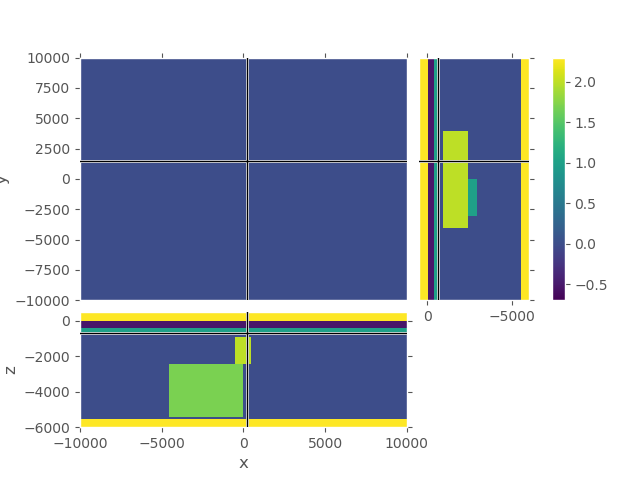

In [17]:
grid.plot_3d_slicer(np.log10(res), clim=np.log10([0.2, 200]))

In [6]:
empymod.Report([discretize])

--------------------------------------------------------------------------------
  Date: Wed Sep 18 16:49:36 2019 CEST

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           15.5 GB : RAM
           Jupyter : Environment

  Python 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]

            0.4.10 : discretize
            1.16.5 : numpy
             1.3.1 : scipy
         1.8.4dev0 : empymod
             2.7.0 : numexpr
             7.8.0 : IPython
             3.1.1 : matplotlib

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------